# Project Final Report: Predicting Newsletter Subscription in MineCraft Server

**Ray Cho, Sienna Juco, Alina Lin, Suri Lui**

## Introduction

As the digital entertainment industry continues to grow, video games have become an important part of many people's lives. Understanding players' behaviours is valuable for gaming companies, as it can help them analyze factors influencing newsletter subscriptions, improving engagement strategies and optimizing recruitment efforts. This prompts us to the question: **Can the combination of a player's experience level, total played hours, and age predict whether they subscribe to newsletters**? 

Minecraft, a sandbox game developed and published in 2011, has gained worldwide popularity among players of all ages. In the game, players can explore, build structures, and interact with a procedurally generated world made of blocks(Minecraft, 2025). Since Minecraft features open-ended gameplay with no fixed objectives, it is an ideal platform for studying player behaviour and engagement patterns. 

A research group in the Computer Science department at the University of British Columbia, led by Frank Wood, has collected data on how people play video games using a Minecraft server. Players' actions are recorded as they navigate the game, forming a dataset that tracks user engagement and personal attributes. This dataset is used to analyze player behavior and compare characteristics between those who subscribe to the newsletter and those who do not.

The data set contains 7 columns and 196 observations:

| Column Name |Data Type | Description|Possible Value/Range| 
|-----------|-------|-------------|-------------|
|  experience| character |Indicates the player’s experience familiarity with the fame |Beginner, Veteran, Regular,Amateur,Pro |
| subscribe |Logical value| player’s subscription status to the game |TRUE, FALSE  |
|hashedEmail  |character |Player’s email(hashed for privacy)|N/A |
|play_hours |numeric |Total hours the players has spent playing in the game |N/A |
|name |character|player’s name |N/A|
|gender|character | Player’s gender|Agender,Male, Female, Non-binary, Two-spirited, Prefer not to Say, Other |
|age| numeric | Player’s Age | N/A|


_This project focuses on developing a k-nearest neighbors (KNN) learning model to predict whether a player will subscribe to a newsletter based on their personal information and playing habits. The optimal k value will be determined through forward selection to achieve the highest prediction accuracy._

## Method and Results

### Loading Relevant Libraries

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
data <- read.csv("./data/players.csv")

# View the first few rows to confirm the data loaded correctly
head(data)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
players <- data |> 
    select(experience, played_hours, Age, subscribe) |>
    mutate(experience=as_factor(experience), subscribe=as_factor(subscribe)) |>
    mutate(Age = if_else(is.na(Age), mean(Age, na.rm = TRUE), Age))
players

experience,played_hours,Age,subscribe
<fct>,<dbl>,<dbl>,<fct>
Pro,30.3,9,TRUE
Veteran,3.8,17,TRUE
Veteran,0.0,17,FALSE
⋮,⋮,⋮,⋮
Amateur,0.0,17.00000,FALSE
Amateur,2.3,17.00000,FALSE
Pro,0.2,20.52062,TRUE


In [4]:
set.seed(123)

player_split <- initial_split(players, prop = 0.8)
player_training <- training(player_split)
player_testing  <- testing(player_split)

In [5]:
player_recipe <- recipe(subscribe ~ ., data = player_training) |>
    step_scale(played_hours, Age) |>
    step_center(played_hours, Age)


In [6]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [7]:
player_vflod = vfold_cv(player_training, v = 5, strata = subscribe)

In [8]:
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vflod, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
knn_results    

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6470833,5,0.03757862,Preprocessor1_Model01
2,accuracy,binary,0.6212500,5,0.04334835,Preprocessor1_Model02
3,accuracy,binary,0.6225000,5,0.04277383,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.7375000,5,0.009293628,Preprocessor1_Model28
29,accuracy,binary,0.7245833,5,0.003572173,Preprocessor1_Model29
30,accuracy,binary,0.7245833,5,0.003572173,Preprocessor1_Model30


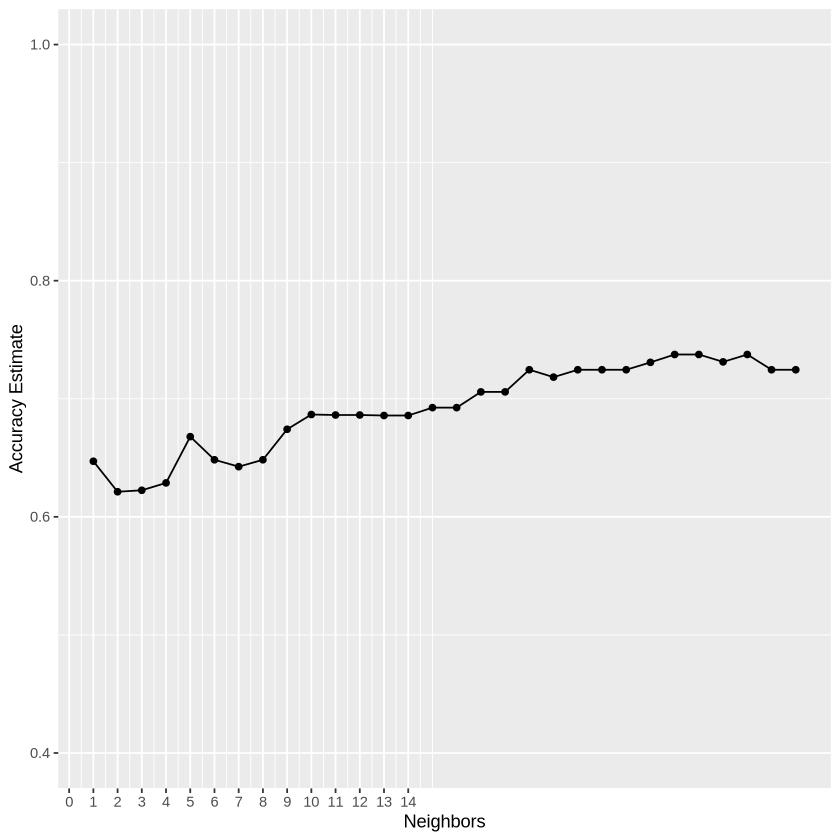

In [9]:
accuracies <- knn_results |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [10]:
knn_results |> slice_max(mean)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.7375,5,0.009293628,Preprocessor1_Model25
26,accuracy,binary,0.7375,5,0.009293628,Preprocessor1_Model26
28,accuracy,binary,0.7375,5,0.009293628,Preprocessor1_Model28


In [11]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_training)

In [12]:
players_predictions <- predict(player_fit, player_testing) |>
    bind_cols(player_testing)

players_metrics <- players_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class)

players_conf_mat <- players_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class)

players_predictions

.pred_class,experience,played_hours,Age,subscribe
<fct>,<fct>,<dbl>,<dbl>,<fct>
TRUE,Veteran,3.8,17,TRUE
TRUE,Veteran,0.0,22,TRUE
TRUE,Veteran,0.0,17,TRUE
⋮,⋮,⋮,⋮,⋮
TRUE,Veteran,0,20,TRUE
TRUE,Regular,0,50,FALSE
TRUE,Pro,0,17,FALSE


In [13]:
players_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75000000
kap,binary,-0.04712042


In [86]:
players_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE      9   30

## Discussion

This analysis explored whether a player's experience level, total play hours, and age had a high probability of predicting subscriptions to newsletters. K-Nearest Neighbors model was applied to the players.csv data to determine if particular variables could indicate a player's likelihood to subscribe. Chosen due to its simple and intuitive algorithm, KNN was used in cross-validation to select and determine the model's optimal number of neighbors (k=26). The final model achieved **an accuracy of 75%**, indicating a **moderate** ability to predict subscriptions based on players' experience, total play hours, and age, as suspected. This accuracy could have been a result of several different factors. For example, not all players in the dataset followed predictable patterns when subscribing to newsletters, meaning that some may have subscribed due to promotions, friends, or random interest, factors that are not necessarily related to the variables chosen. This randomness prevents KNN from producing accurate predictions, thus lowering the model's accuracy. Furthermore, the confusion matrix produced by the data provided compelling insights. The model correctly predicted 30 true positives, meaning it successfully identified 30 real subscribers. This statistic gives rise to a 100% calculated recall (using the recall formula with the confusion matrix), suggesting that the model does not miss any actual subscribers–it identifies all of them. Yet, the model produces 9 false positives; therefore, it incorrectly classified 9 players as subscribers when they were not. Interestingly, the model had 0 false negatives, meaning it did not misidentify any actual subscribers, and only had 1 true negative, or 1 non-subscriber. Using this data, **a precision of ~77%** was calculated (through a precision formula with the confusion matrix), signifying that 23% of players who were predicted to be subscribers were not. This implies that the model is highly biased towards predicting subscriptions, which could raise questions about the dataset. For instance, if the training data contains more subscribers than non-subscribers, the model may be predisposed to predicting “true” leading to an overestimation of subscriptions.
    
Although the model was not completely accurate, it could have practical implications. As stated previously, the model is around 75% accurate, suggesting that the variables–experience level, total play hours, and age— do provide some predictive influence on subscription behavior, which could be valuable for a number of different reasons. In particular, this information could be useful for marketing teams wanting to expand outreach to identify groups that are likely to subscribe to newsletters, perhaps those within a certain age group or a certain experience level. By using this data, they can develop more targeted marketing strategies and methods to boost player subscription levels. Additionally, this information could also help the game developers tailor content more suitable to its users. For example, if a lot of those subscribing are veteran users, then the content in the game could be more advanced; in contrast, if a majority of players subscribing are beginners, the game could be tailored to be more accessible. 
    
The results from this analysis also lead to further questions, such as if the selected variables are sufficient to predict subscription behavior or if other variables would be more suitable—like in-game purchases, weekly game play, amount of friends—which could provide more accurate predictions. Additionally, in the future one could conduct even more data analysis to determine a concrete relationship to ensure that this result is common amongst the entire population of gamers and not just the subset that participated in this particular study. Overall, this KNN model provides a foundation for understanding subscription likelihood, although analysis of additional variables and expansion of the dataset could be completed to create a more reliable prediction model.

## Reference

Wikimedia Foundation. (2025b, April 3). Minecraft. Wikipedia. 
    https://en.wikipedia.org/wiki/Minecraft 